# Model Training & Testing
This notebook is intended to help train and test various models, and expanded from our data_model_prep notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from fastai.tabular.all import *
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

import os
import pickle

random_state = 42
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Set up paths

In [2]:
# For python pipeline that will be run from root folder of project
# ROOT_DIR = os.path.abspath(os.curdir)

# # Pickle save paths
# training_df_path = os.path.join(ROOT_DIR,"data/processed/training_df.pkl")
# testing_df_path = os.path.join(ROOT_DIR,"data/processed/testing_df.pkl")

# Relative path for notebook
training_df_path = "../data/processed/training_df.pkl"
testing_df_path = "../data/processed/testing_df.pkl"

# Small df for testing
training_df_small_path = "../data/processed/training_df_small.pkl"
# Big df for testing
randompct10_pklpath=r"/run/user/1000/gvfs/smb-share:server=metebox,share=data/JAMES/datasets/youtube-meta/youtube-02-2019-dump/randompct_df_10.pkl"

## Load training and test dataframes

In [3]:
# training_df = pd.read_pickle(training_df_path)
testing_df = pd.read_pickle(testing_df_path)

# big df
# training_df_big = pd.read_pickle(randompct10_pklpath)

# small df
training_df = pd.read_pickle(training_df_small_path)

In [14]:
# Concat training df and training_df_big for testing if more data helps
# training_df = pd.concat([training_df,training_df_big])
# training_df = training_df.sample(frac=1).reset_index(drop=True)

## Columns for model training

In [4]:
# Based on what we can get at inference time from the Youtube API or scraping
X_cols = [
    "duration",
    "age_limit",
    "view_count",
    "like_count",
    "view_like_ratio",
    "is_comments_enabled",
    "is_live_content",
    "cat_codes",
    "neu",
    "neg",
    "pos",
    "compound",
]

y_col = "ld_score_ohe"

# Get all related columns - useful for fastai models
all_related_cols = X_cols.copy()
all_related_cols.append(y_col)

In [5]:
# Testing scaled versions
scaler = StandardScaler()
training_df_scaled_X = scaler.fit_transform(training_df[X_cols])
testing_df_scaled_X = scaler.transform(testing_df[X_cols])

## Helper Functions

In [6]:
def create_training_test_sets(df,X_cols,y_col,random_state=None):
    """
    Takes in a processed dataframe and splits it into appropriate training and test splits.
    """
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state)
    print("Splits created")
    return X, y, X_train, X_test, y_train,y_test

def train_model(clf_object,model_name,X_train,y_train,X_test,y_test):
    clf_object.fit(X_train,y_train)
    acc, f1 = test_model_metrics(clf=clf_object,model_name=model_name)
    return clf_object, acc, f1

def test_model_metrics(clf, model_name,X_test,y_test):
    testpreds = clf.predict(X_test)
    acc = accuracy_score(y_test,testpreds)
    
    if len(y_test.unique()) > 2:
        average = "weighted"
    else:
        average = "binary"
        
    f1 = f1_score(y_test,testpreds,average=average)
    print(f"{model_name} metrics:")
    print(f"Accuracy Score: {acc}")
    print(f"F1 score: {f1}")
    return acc,f1

def cross_val_model(df,clf_object,X_cols,y_col,random_state,scoring,cv=5):
    """
    Takes in a df, processes it, and then outputs a cross-validation f1 score.
    Adapted from sklearn docs.
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    scores = cross_val_score(clf_object, X, y, cv=cv,scoring=scoring,verbose=1,n_jobs=-1)
    print(f"{scores.mean():0.2f} {scoring} with a standard deviation of {scores.std():0.2f}")
    return scores

def confusion_matrix_model(df,clf_object,X_cols,y_col,random_state,model_name):
    """
    Takes in a df, processes it, and then outputs a confusion matrix.
    Adapted from sklearn docs: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    clf_object.fit(X_train,y_train)
    
    # Adapted from sklearn docs
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        (f"{model_name} Confusion matrix, without normalization", None),
        (f"{model_name} Normalized confusion matrix", "true"),
    ]
    
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf_object,
            X_test,
            y_test,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

## Model Training

### Random Forest

In [7]:
# Training model
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])

Random Forest metrics:
Accuracy Score: 0.8010047084121158
F1 score: 0.7777931664635174


RF Confusion Matrix
[[0.87886563 0.0218321  0.09930227]
 [0.42575647 0.09519601 0.47904752]
 [0.09678625 0.00381264 0.89940111]]


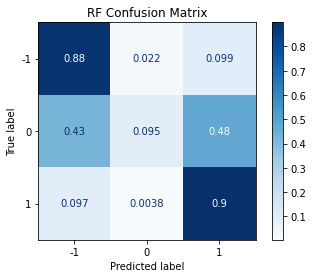

In [8]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

Random Forest-Scaled metrics:
Accuracy Score: 0.8043599154710266
F1 score: 0.7800643006431393
RF Confusion Matrix-Scaled
[[0.87625478 0.0218321  0.10191312]
 [0.41832172 0.09504003 0.48663824]
 [0.09284071 0.00274111 0.90441818]]


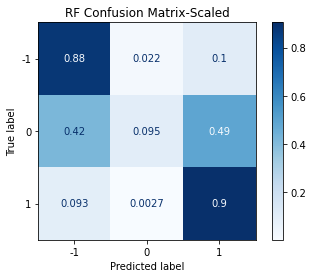

In [9]:
# Training model - scaled
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix-Scaled")

print("RF Confusion Matrix-Scaled")
print(disp.confusion_matrix)

### GBM

In [10]:
# Training model
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df[X_cols],training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM",testing_df[X_cols],testing_df[y_col])

GBM metrics:
Accuracy Score: 0.8160011863715567
F1 score: 0.7907486733672126


GBM Confusion Matrix
[[0.86234526 0.03011479 0.10753995]
 [0.37080171 0.11380888 0.51538941]
 [0.07906038 0.00130411 0.91963551]]


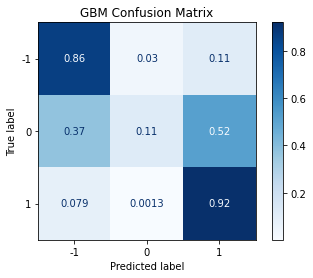

In [11]:
disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix")

print("GBM Confusion Matrix")
print(disp.confusion_matrix)

GBM-Scaled metrics:
Accuracy Score: 0.8185963741519298
F1 score: 0.7941335622498457
GBM Confusion Matrix-Scaled
[[0.85725861 0.03443619 0.1083052 ]
 [0.35619216 0.12529895 0.51850889]
 [0.07671797 0.00105491 0.92222711]]


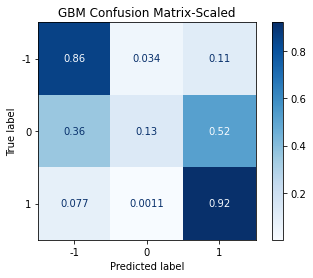

In [12]:
# Training model - scaled version
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df_scaled_X,training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix-Scaled")

print("GBM Confusion Matrix-Scaled")
print(disp.confusion_matrix)

### Neural Net
We will use sklearn mlp and fastai to create a tabular learner neural net

Iteration 1, loss = 4.42950026
Iteration 2, loss = 3.57755761
Iteration 3, loss = 3.78824876
Iteration 4, loss = 3.41177869
Iteration 5, loss = 4.03336538
Iteration 6, loss = 3.35087394
Iteration 7, loss = 3.38560261
Iteration 8, loss = 3.09514178
Iteration 9, loss = 3.04404880
Iteration 10, loss = 3.02739196
Iteration 11, loss = 2.99754585
Iteration 12, loss = 2.95538401
Iteration 13, loss = 3.20878666
Iteration 14, loss = 3.05539064
Iteration 15, loss = 2.96147884
Iteration 16, loss = 2.90450433
Iteration 17, loss = 3.06705597
Iteration 18, loss = 3.11175691
Iteration 19, loss = 3.08573033
Iteration 20, loss = 3.32206599
Iteration 21, loss = 2.96553022
Iteration 22, loss = 3.31645275
Iteration 23, loss = 2.89414545
Iteration 24, loss = 3.21414995
Iteration 25, loss = 2.76381431
Iteration 26, loss = 2.70946889
Iteration 27, loss = 2.71693304
Iteration 28, loss = 2.99674700
Iteration 29, loss = 3.24565714
Iteration 30, loss = 3.46214256
Iteration 31, loss = 3.34380238
Iteration 32, los

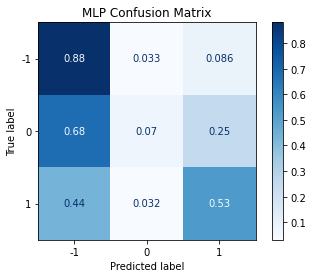

In [13]:
%%time
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=2)
mlp_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix")

print("MLP Confusion Matrix")
print(disp.confusion_matrix)

Iteration 1, loss = 0.47613949
Iteration 2, loss = 0.37496478
Iteration 3, loss = 0.35207984
Iteration 4, loss = 0.33903542
Iteration 5, loss = 0.33085433
Iteration 6, loss = 0.32486646
Iteration 7, loss = 0.32012718
Iteration 8, loss = 0.31563970
Iteration 9, loss = 0.31146543
Iteration 10, loss = 0.30746494
Iteration 11, loss = 0.30369885
Iteration 12, loss = 0.30047257
Iteration 13, loss = 0.29749642
Iteration 14, loss = 0.29466035
Iteration 15, loss = 0.29177855
Iteration 16, loss = 0.28900387
Iteration 17, loss = 0.28559381
Iteration 18, loss = 0.28316940
Iteration 19, loss = 0.28047900
Iteration 20, loss = 0.27894433
Iteration 21, loss = 0.27648915
Iteration 22, loss = 0.27461064
Iteration 23, loss = 0.27301444
Iteration 24, loss = 0.27134990
Iteration 25, loss = 0.26969515
Iteration 26, loss = 0.26858023
Iteration 27, loss = 0.26776555
Iteration 28, loss = 0.26581328
Iteration 29, loss = 0.26545548
Iteration 30, loss = 0.26447768
Iteration 31, loss = 0.26325001
Iteration 32, los

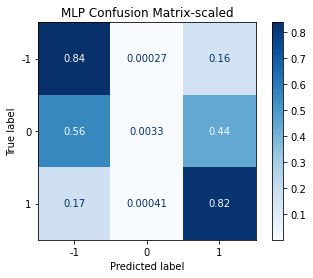

In [14]:
%%time 
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP-scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-scaled")

print("MLP Confusion Matrix-scaled")
print(disp.confusion_matrix)

In [ ]:
# Gridsearch MLP
# Inspired by https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_base = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf_grid = GridSearchCV(mlp_base, parameter_space, n_jobs=-1, cv=3)
mlp_clf_grid.fit(training_df_scaled_X,training_df[y_col])

mlp_scaled_best_params = mlp_clf_grid.best_params_
print("MLP Scaled Best Params found through grid search cv are:")
print(mlp_scaled_best_params)

# Testing model
mlp_acc_grid,mlp_f1_grid = test_model_metrics(mlp_clf_grid,"MLP-scaled-Gridsearch",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf_grid,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix-scaled-Gridsearch")

print("MLP Confusion Matrix-scaled-Gridsearch")
print(disp.confusion_matrix)


Iteration 1, loss = 0.63144775
Iteration 2, loss = 0.54512569
Iteration 3, loss = 0.45330666
Iteration 4, loss = 0.39835150
Iteration 5, loss = 0.37696999
Iteration 6, loss = 0.36801918
Iteration 7, loss = 0.36305321
Iteration 8, loss = 0.35949449
Iteration 9, loss = 0.35678872
Iteration 10, loss = 0.35473460
Iteration 11, loss = 0.35340710
Iteration 12, loss = 0.35176888
Iteration 13, loss = 0.35076742
Iteration 14, loss = 0.34945714
Iteration 15, loss = 0.34864483
Iteration 16, loss = 0.34731462
Iteration 17, loss = 0.34642831
Iteration 18, loss = 0.34489974
Iteration 19, loss = 0.34420313
Iteration 20, loss = 0.34346078
Iteration 21, loss = 0.34273646
Iteration 22, loss = 0.34168430
Iteration 23, loss = 0.34086170
Iteration 24, loss = 0.34002766
Iteration 25, loss = 0.33885551
Iteration 26, loss = 0.33844845
Iteration 27, loss = 0.33781648
Iteration 28, loss = 0.33645535
Iteration 29, loss = 0.33637092
Iteration 30, loss = 0.33535660
Iteration 31, loss = 0.33466422
Iteration 32, los

Iteration 1, loss = 0.63169453
Iteration 2, loss = 0.54499864
Iteration 3, loss = 0.45303484
Iteration 4, loss = 0.39845655
Iteration 5, loss = 0.37696366
Iteration 6, loss = 0.36851589
Iteration 7, loss = 0.36332825
Iteration 8, loss = 0.35977827
Iteration 9, loss = 0.35740088
Iteration 10, loss = 0.35586347
Iteration 11, loss = 0.35349730
Iteration 12, loss = 0.35233248
Iteration 13, loss = 0.35077033
Iteration 14, loss = 0.34964713
Iteration 15, loss = 0.34838108
Iteration 16, loss = 0.34755449
Iteration 17, loss = 0.34658101
Iteration 18, loss = 0.34549165
Iteration 19, loss = 0.34444446
Iteration 20, loss = 0.34348907
Iteration 21, loss = 0.34289409
Iteration 22, loss = 0.34177000
Iteration 23, loss = 0.34117601
Iteration 24, loss = 0.34027755
Iteration 25, loss = 0.33879621
Iteration 26, loss = 0.33853807
Iteration 27, loss = 0.33794820
Iteration 28, loss = 0.33708337
Iteration 29, loss = 0.33594086
Iteration 30, loss = 0.33515553
Iteration 31, loss = 0.33445560
Iteration 32, los

Iteration 1, loss = 0.63144775
Iteration 2, loss = 0.54512569
Iteration 3, loss = 0.45330666
Iteration 4, loss = 0.39835150
Iteration 5, loss = 0.37696999
Iteration 6, loss = 0.36801918
Iteration 7, loss = 0.36305321
Iteration 8, loss = 0.35949449
Iteration 9, loss = 0.35678872
Iteration 10, loss = 0.35473460
Iteration 11, loss = 0.35340710
Iteration 12, loss = 0.35176888
Iteration 13, loss = 0.35076742
Iteration 14, loss = 0.34945714
Iteration 15, loss = 0.34864483
Iteration 16, loss = 0.34731462
Iteration 17, loss = 0.34642831
Iteration 18, loss = 0.34489974
Iteration 19, loss = 0.34420313
Iteration 20, loss = 0.34346078
Iteration 21, loss = 0.34273646
Iteration 22, loss = 0.34168430
Iteration 23, loss = 0.34086170
Iteration 24, loss = 0.34002766
Iteration 25, loss = 0.33885551
Iteration 26, loss = 0.33844845
Iteration 27, loss = 0.33781648
Iteration 28, loss = 0.33645535
Iteration 29, loss = 0.33637092
Iteration 30, loss = 0.33535660
Iteration 31, loss = 0.33466422
Iteration 32, los

Iteration 1, loss = 0.41950013
Iteration 2, loss = 0.35947995
Iteration 3, loss = 0.34715154
Iteration 4, loss = 0.33853379
Iteration 5, loss = 0.33076563
Iteration 6, loss = 0.32602897
Iteration 7, loss = 0.32260993
Iteration 8, loss = 0.31890063
Iteration 9, loss = 0.31278507
Iteration 10, loss = 0.30712618
Iteration 11, loss = 0.30342862
Iteration 12, loss = 0.29909694
Iteration 13, loss = 0.29573207
Iteration 14, loss = 0.29169488
Iteration 15, loss = 0.29041709
Iteration 16, loss = 0.28756977
Iteration 17, loss = 0.28731327
Iteration 18, loss = 0.28466933
Iteration 19, loss = 0.28307872
Iteration 20, loss = 0.28144355
Iteration 21, loss = 0.27824161
Iteration 22, loss = 0.27645172
Iteration 23, loss = 0.27631374
Iteration 24, loss = 0.27296271
Iteration 25, loss = 0.27126973
Iteration 26, loss = 0.26902900
Iteration 27, loss = 0.26882050
Iteration 28, loss = 0.26649257
Iteration 29, loss = 0.26301996
Iteration 30, loss = 0.26017758
Iteration 31, loss = 0.25989905
Iteration 32, los

Iteration 1, loss = 0.41994397
Iteration 2, loss = 0.35968288
Iteration 3, loss = 0.34732312
Iteration 4, loss = 0.34004328
Iteration 5, loss = 0.33307538
Iteration 6, loss = 0.32690443
Iteration 7, loss = 0.32378484
Iteration 8, loss = 0.31918060
Iteration 9, loss = 0.31414745
Iteration 10, loss = 0.30907707
Iteration 11, loss = 0.30351506
Iteration 12, loss = 0.29993285
Iteration 13, loss = 0.29784088
Iteration 14, loss = 0.29370831
Iteration 15, loss = 0.29064966
Iteration 16, loss = 0.28885549
Iteration 17, loss = 0.28768360
Iteration 18, loss = 0.28517379
Iteration 19, loss = 0.28214756
Iteration 20, loss = 0.28049577
Iteration 21, loss = 0.27897162
Iteration 22, loss = 0.27682900
Iteration 23, loss = 0.27638972
Iteration 24, loss = 0.27353858
Iteration 25, loss = 0.27323029
Iteration 26, loss = 0.27002129
Iteration 27, loss = 0.26934200
Iteration 28, loss = 0.26729355
Iteration 29, loss = 0.26584277
Iteration 30, loss = 0.26517104
Iteration 31, loss = 0.26170337
Iteration 32, los

Iteration 1, loss = 0.41821725
Iteration 2, loss = 0.35938982
Iteration 3, loss = 0.34782301
Iteration 4, loss = 0.34124944
Iteration 5, loss = 0.33300249
Iteration 6, loss = 0.32740301
Iteration 7, loss = 0.32387178
Iteration 8, loss = 0.32019316
Iteration 9, loss = 0.31544302
Iteration 10, loss = 0.30999776
Iteration 11, loss = 0.30571020
Iteration 12, loss = 0.30115249
Iteration 13, loss = 0.29761386
Iteration 14, loss = 0.29424112
Iteration 15, loss = 0.29247038
Iteration 16, loss = 0.28894527
Iteration 17, loss = 0.28780162
Iteration 18, loss = 0.28539979
Iteration 19, loss = 0.28375012
Iteration 20, loss = 0.28333413
Iteration 21, loss = 0.28047911
Iteration 22, loss = 0.27861651
Iteration 23, loss = 0.27844091
Iteration 24, loss = 0.27635505
Iteration 25, loss = 0.27321848
Iteration 26, loss = 0.27130914
Iteration 27, loss = 0.27099200
Iteration 28, loss = 0.27042182
Iteration 29, loss = 0.26961930
Iteration 30, loss = 0.26634607
Iteration 31, loss = 0.26576133
Iteration 32, los

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.41821725
Iteration 2, loss = 0.35938982
Iteration 3, loss = 0.34782301
Iteration 4, loss = 0.34124944
Iteration 5, loss = 0.33300249
Iteration 6, loss = 0.32740301
Iteration 7, loss = 0.32387178
Iteration 8, loss = 0.32019316
Iteration 9, loss = 0.31544302
Iteration 10, loss = 0.30999776
Iteration 11, loss = 0.30571020
Iteration 12, loss = 0.30115249
Iteration 13, loss = 0.29761386
Iteration 14, loss = 0.29424112
Iteration 15, loss = 0.29247038
Iteration 16, loss = 0.28894527
Iteration 17, loss = 0.28780162
Iteration 18, loss = 0.28539979
Iteration 19, loss = 0.28375012
Iteration 20, loss = 0.28333413
Iteration 21, loss = 0.28047911
Iteration 22, loss = 0.27861651
Iteration 23, loss = 0.27844091
Iteration 24, loss = 0.27635505
Iteration 25, loss = 0.27321848
Iteration 26, loss = 0.27130914
Iteration 27, loss = 0.27099200
Iteration 28, loss = 0.27042182
Iteration 29, loss = 0.26961930
Iteration 30, loss = 0.26634607
Iteration 31, loss = 0.26576133
Iteration 32, los

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) 

Iteration 252, loss = 0.22348120
Iteration 253, loss = 0.22150547
Iteration 254, loss = 0.22129646
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.41841079
Iteration 2, loss = 0.35889440
Iteration 3, loss = 0.34666020
Iteration 4, loss = 0.33899210
Iteration 5, loss = 0.33224438
Iteration 6, loss = 0.32402830
Iteration 7, loss = 0.31749444
Iteration 8, loss = 0.31101482
Iteration 9, loss = 0.30257560
Iteration 10, loss = 0.29871035
Iteration 11, loss = 0.29399708
Iteration 12, loss = 0.29051971
Iteration 13, loss = 0.28725489
Iteration 14, loss = 0.28539865
Iteration 15, loss = 0.28278547
Iteration 16, loss = 0.27967698
Iteration 17, loss = 0.27752868
Iteration 18, loss = 0.27689634
Iteration 19, loss = 0.27526338
Iteration 20, loss = 0.27305753
Iteration 21, loss = 0.27175613
Iteration 22, loss = 0.27077759
Iteration 23, loss = 0.26806078
Iteration 24, loss = 0.26721101
Iteration 25, loss = 0.26640061
Iteration 26, loss =

Iteration 72, loss = 0.24001597
Iteration 73, loss = 0.23943949
Iteration 74, loss = 0.23933001
Iteration 75, loss = 0.24036836
Iteration 76, loss = 0.23939833
Iteration 77, loss = 0.23930227
Iteration 78, loss = 0.23912687
Iteration 79, loss = 0.23960154
Iteration 80, loss = 0.23856309
Iteration 81, loss = 0.23913822
Iteration 82, loss = 0.23823749
Iteration 83, loss = 0.23667306
Iteration 84, loss = 0.23872659
Iteration 85, loss = 0.23894523
Iteration 86, loss = 0.23764981
Iteration 87, loss = 0.23842497
Iteration 88, loss = 0.23830929
Iteration 89, loss = 0.23803377
Iteration 90, loss = 0.23678242
Iteration 91, loss = 0.23558817
Iteration 92, loss = 0.23622707
Iteration 93, loss = 0.23649178
Iteration 94, loss = 0.23574752
Iteration 95, loss = 0.23576938
Iteration 96, loss = 0.23598699
Iteration 97, loss = 0.23655469
Iteration 98, loss = 0.23648204
Iteration 99, loss = 0.23615831
Iteration 100, loss = 0.23570226
Iteration 101, loss = 0.23435094
Iteration 102, loss = 0.23518063
Itera

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 252, loss = 0.22348120
Iteration 253, loss = 0.22150547
Iteration 254, loss = 0.22129646
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.41925204
Iteration 2, loss = 0.35769312
Iteration 3, loss = 0.34593948
Iteration 4, loss = 0.33760829
Iteration 5, loss = 0.33037981
Iteration 6, loss = 0.32598350
Iteration 7, loss = 0.32160661
Iteration 8, loss = 0.31751030
Iteration 9, loss = 0.31087344
Iteration 10, loss = 0.30591202
Iteration 11, loss = 0.30225875
Iteration 12, loss = 0.29815404
Iteration 13, loss = 0.29374406
Iteration 14, loss = 0.28991595
Iteration 15, loss = 0.28753631
Iteration 16, loss = 0.28409139
Iteration 17, loss = 0.28213790
Iteration 18, loss = 0.28009124
Iteration 19, loss = 0.27645087
Iteration 20, loss = 0.27603817
Iteration 21, loss = 0.27501639
Iteration 22, loss = 0.27324449
Iteration 23, loss = 0.27067212
Iteration 24, loss = 0.27064439
Iteration 25, loss = 0.26808315
Iteration 26, loss =

Iteration 252, loss = 0.28008155
Iteration 253, loss = 0.27951919
Iteration 254, loss = 0.27962317
Iteration 255, loss = 0.27988080
Iteration 256, loss = 0.27986827
Iteration 257, loss = 0.27941192
Iteration 258, loss = 0.27959394
Iteration 259, loss = 0.27930321
Iteration 260, loss = 0.27902233
Iteration 261, loss = 0.27892441
Iteration 262, loss = 0.27906118
Iteration 263, loss = 0.27864037
Iteration 264, loss = 0.27892579
Iteration 265, loss = 0.27844614
Iteration 266, loss = 0.27813151
Iteration 267, loss = 0.27845934
Iteration 268, loss = 0.27793719
Iteration 269, loss = 0.27772792
Iteration 270, loss = 0.27773731
Iteration 271, loss = 0.27755737
Iteration 272, loss = 0.27801606
Iteration 273, loss = 0.27722057
Iteration 274, loss = 0.27698081
Iteration 275, loss = 0.27670038
Iteration 276, loss = 0.27663265
Iteration 277, loss = 0.27669203
Iteration 278, loss = 0.27639759
Iteration 279, loss = 0.27670682
Iteration 280, loss = 0.27655187
Iteration 281, loss = 0.27539968
Iteration 

Iteration 252, loss = 0.28008155
Iteration 253, loss = 0.27951919
Iteration 254, loss = 0.27962317
Iteration 255, loss = 0.27988080
Iteration 256, loss = 0.27986827
Iteration 257, loss = 0.27941192
Iteration 258, loss = 0.27959394
Iteration 259, loss = 0.27930321
Iteration 260, loss = 0.27902233
Iteration 261, loss = 0.27892441
Iteration 262, loss = 0.27906118
Iteration 263, loss = 0.27864037
Iteration 264, loss = 0.27892579
Iteration 265, loss = 0.27844614
Iteration 266, loss = 0.27813151
Iteration 267, loss = 0.27845934
Iteration 268, loss = 0.27793719
Iteration 269, loss = 0.27772792
Iteration 270, loss = 0.27773731
Iteration 271, loss = 0.27755737
Iteration 272, loss = 0.27801606
Iteration 273, loss = 0.27722057
Iteration 274, loss = 0.27698081
Iteration 275, loss = 0.27670038
Iteration 276, loss = 0.27663265
Iteration 277, loss = 0.27669203
Iteration 278, loss = 0.27639759
Iteration 279, loss = 0.27670682
Iteration 280, loss = 0.27655187
Iteration 281, loss = 0.27539968
Iteration 

Iteration 138, loss = 0.29454818
Iteration 139, loss = 0.29460688
Iteration 140, loss = 0.29377684
Iteration 141, loss = 0.29394910
Iteration 142, loss = 0.29457716
Iteration 143, loss = 0.29372483
Iteration 144, loss = 0.29334186
Iteration 145, loss = 0.29350848
Iteration 146, loss = 0.29384068
Iteration 147, loss = 0.29342100
Iteration 148, loss = 0.29319818
Iteration 149, loss = 0.29307567
Iteration 150, loss = 0.29288304
Iteration 151, loss = 0.29261625
Iteration 152, loss = 0.29218104
Iteration 153, loss = 0.29277430
Iteration 154, loss = 0.29255116
Iteration 155, loss = 0.29266805
Iteration 156, loss = 0.29171362
Iteration 157, loss = 0.29173504
Iteration 158, loss = 0.29169405
Iteration 159, loss = 0.29083848
Iteration 160, loss = 0.29136416
Iteration 161, loss = 0.29143158
Iteration 162, loss = 0.29105505
Iteration 163, loss = 0.29057818
Iteration 164, loss = 0.29075169
Iteration 165, loss = 0.29035454
Iteration 166, loss = 0.29075485
Iteration 167, loss = 0.29059606
Iteration 

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 72, loss = 0.31272416
Iteration 73, loss = 0.31203532
Iteration 74, loss = 0.31190194
Iteration 75, loss = 0.31146338
Iteration 76, loss = 0.31129825
Iteration 77, loss = 0.31066697
Iteration 78, loss = 0.31075881
Iteration 79, loss = 0.31038178
Iteration 80, loss = 0.30983342
Iteration 81, loss = 0.30939032
Iteration 82, loss = 0.30924553
Iteration 83, loss = 0.30881035
Iteration 84, loss = 0.30864497
Iteration 85, loss = 0.30834894
Iteration 86, loss = 0.30811707
Iteration 87, loss = 0.30783303
Iteration 88, loss = 0.30776580
Iteration 89, loss = 0.30763639
Iteration 90, loss = 0.30662990
Iteration 91, loss = 0.30654484
Iteration 92, loss = 0.30686139
Iteration 93, loss = 0.30602141
Iteration 94, loss = 0.30530534
Iteration 95, loss = 0.30564788
Iteration 96, loss = 0.30501211
Iteration 97, loss = 0.30431501
Iteration 98, loss = 0.30499454
Iteration 99, loss = 0.30397760
Iteration 100, loss = 0.30407133
Iteration 101, loss = 0.30377614
Iteration 102, loss = 0.30328356
Itera

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 159, loss = 0.33937009
Iteration 160, loss = 0.33926251
Iteration 161, loss = 0.33914310
Iteration 162, loss = 0.33900870
Iteration 163, loss = 0.33891775
Iteration 164, loss = 0.33870212
Iteration 165, loss = 0.33872430
Iteration 166, loss = 0.33857349
Iteration 167, loss = 0.33835747
Iteration 168, loss = 0.33826044
Iteration 169, loss = 0.33831052
Iteration 170, loss = 0.33809112
Iteration 171, loss = 0.33818645
Iteration 172, loss = 0.33789179
Iteration 173, loss = 0.33796274
Iteration 174, loss = 0.33774396
Iteration 175, loss = 0.33777199
Iteration 176, loss = 0.33767553
Iteration 177, loss = 0.33756893
Iteration 178, loss = 0.33741470
Iteration 179, loss = 0.33723166
Iteration 180, loss = 0.33717151
Iteration 181, loss = 0.33713609
Iteration 182, loss = 0.33704695
Iteration 183, loss = 0.33687282
Iteration 184, loss = 0.33680482
Iteration 185, loss = 0.33670757
Iteration 186, loss = 0.33663875
Iteration 187, loss = 0.33647226
Iteration 188, loss = 0.33651546
Iteration 

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 115, loss = 0.34445522
Iteration 116, loss = 0.34429934
Iteration 117, loss = 0.34398676
Iteration 118, loss = 0.34398389
Iteration 119, loss = 0.34393496
Iteration 120, loss = 0.34376099
Iteration 121, loss = 0.34347222
Iteration 122, loss = 0.34345191
Iteration 123, loss = 0.34322040
Iteration 124, loss = 0.34308122
Iteration 125, loss = 0.34305010
Iteration 126, loss = 0.34295058
Iteration 127, loss = 0.34276990
Iteration 128, loss = 0.34261965
Iteration 129, loss = 0.34256295
Iteration 130, loss = 0.34240487
Iteration 131, loss = 0.34232739
Iteration 132, loss = 0.34228589
Iteration 133, loss = 0.34208287
Iteration 134, loss = 0.34201362
Iteration 135, loss = 0.34181887
Iteration 136, loss = 0.34169405
Iteration 137, loss = 0.34155116
Iteration 138, loss = 0.34152433
Iteration 139, loss = 0.34131405
Iteration 140, loss = 0.34115381
Iteration 141, loss = 0.34116126
Iteration 142, loss = 0.34106996
Iteration 143, loss = 0.34077620
Iteration 144, loss = 0.34080656
Iteration 

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) 

Iteration 37, loss = 0.37461783
Iteration 38, loss = 0.37351878
Iteration 39, loss = 0.37234627
Iteration 40, loss = 0.37149119
Iteration 41, loss = 0.37045994
Iteration 42, loss = 0.36954752
Iteration 43, loss = 0.36870732
Iteration 44, loss = 0.36781391
Iteration 45, loss = 0.36697454
Iteration 46, loss = 0.36622966
Iteration 47, loss = 0.36549643
Iteration 48, loss = 0.36475688
Iteration 49, loss = 0.36399957
Iteration 50, loss = 0.36328215
Iteration 51, loss = 0.36269524
Iteration 52, loss = 0.36203304
Iteration 53, loss = 0.36139561
Iteration 54, loss = 0.36078175
Iteration 55, loss = 0.36020856
Iteration 56, loss = 0.35965520
Iteration 57, loss = 0.35920780
Iteration 58, loss = 0.35860019
Iteration 59, loss = 0.35818077
Iteration 60, loss = 0.35780487
Iteration 61, loss = 0.35713066
Iteration 62, loss = 0.35670663
Iteration 63, loss = 0.35628245
Iteration 64, loss = 0.35587962
Iteration 65, loss = 0.35537927
Iteration 66, loss = 0.35491714
Iteration 67, loss = 0.35461741
Iteratio

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 72, loss = 0.31751443
Iteration 73, loss = 0.31731134
Iteration 74, loss = 0.31727201
Iteration 75, loss = 0.31708553
Iteration 76, loss = 0.31716190
Iteration 77, loss = 0.31665076
Iteration 78, loss = 0.31669724
Iteration 79, loss = 0.31624592
Iteration 80, loss = 0.31645405
Iteration 81, loss = 0.31621953
Iteration 82, loss = 0.31639771
Iteration 83, loss = 0.31595444
Iteration 84, loss = 0.31557064
Iteration 85, loss = 0.31535536
Iteration 86, loss = 0.31559340
Iteration 87, loss = 0.31513527
Iteration 88, loss = 0.31543188
Iteration 89, loss = 0.31503692
Iteration 90, loss = 0.31485891
Iteration 91, loss = 0.31462650
Iteration 92, loss = 0.31458897
Iteration 93, loss = 0.31467571
Iteration 94, loss = 0.31447775
Iteration 95, loss = 0.31386892
Iteration 96, loss = 0.31421432
Iteration 97, loss = 0.31388257
Iteration 98, loss = 0.31399723
Iteration 99, loss = 0.31369137
Iteration 100, loss = 0.31359914
Iteration 101, loss = 0.31353297
Iteration 102, loss = 0.31334404
Itera

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 116, loss = 0.31249222
Iteration 117, loss = 0.31196467
Iteration 118, loss = 0.31141109
Iteration 119, loss = 0.31158020
Iteration 120, loss = 0.31164469
Iteration 121, loss = 0.31154876
Iteration 122, loss = 0.31110570
Iteration 123, loss = 0.31086531
Iteration 124, loss = 0.31089524
Iteration 125, loss = 0.31092037
Iteration 126, loss = 0.31053366
Iteration 127, loss = 0.31054480
Iteration 128, loss = 0.31042617
Iteration 129, loss = 0.31051928
Iteration 130, loss = 0.31042666
Iteration 131, loss = 0.31001182
Iteration 132, loss = 0.31003630
Iteration 133, loss = 0.30979987
Iteration 134, loss = 0.30950395
Iteration 135, loss = 0.30960451
Iteration 136, loss = 0.30946620
Iteration 137, loss = 0.30939964
Iteration 138, loss = 0.30908222
Iteration 139, loss = 0.30927306
Iteration 140, loss = 0.30875772
Iteration 141, loss = 0.30883996
Iteration 142, loss = 0.30838597
Iteration 143, loss = 0.30853086
Iteration 144, loss = 0.30840206
Iteration 145, loss = 0.30805454
Iteration 

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 89, loss = 0.34936567
Iteration 90, loss = 0.34935817
Iteration 91, loss = 0.34891883
Iteration 92, loss = 0.34883452
Iteration 93, loss = 0.34852635
Iteration 94, loss = 0.34849799
Iteration 95, loss = 0.34814407
Iteration 96, loss = 0.34780084
Iteration 97, loss = 0.34757585
Iteration 98, loss = 0.34751090
Iteration 99, loss = 0.34726537
Iteration 100, loss = 0.34715553
Iteration 101, loss = 0.34700683
Iteration 102, loss = 0.34687738
Iteration 103, loss = 0.34644771
Iteration 104, loss = 0.34652748
Iteration 105, loss = 0.34618680
Iteration 106, loss = 0.34603850
Iteration 107, loss = 0.34583801
Iteration 108, loss = 0.34572471
Iteration 109, loss = 0.34548470
Iteration 110, loss = 0.34534053
Iteration 111, loss = 0.34525901
Iteration 112, loss = 0.34508351
Iteration 113, loss = 0.34498193
Iteration 114, loss = 0.34473048
Iteration 115, loss = 0.34454339
Iteration 116, loss = 0.34448277
Iteration 117, loss = 0.34429999
Iteration 118, loss = 0.34400643
Iteration 119, loss =

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 22, loss = 0.33287917
Iteration 23, loss = 0.33241103
Iteration 24, loss = 0.33159133
Iteration 25, loss = 0.33058386
Iteration 26, loss = 0.33030558
Iteration 27, loss = 0.32952108
Iteration 28, loss = 0.32931366
Iteration 29, loss = 0.32871757
Iteration 30, loss = 0.32815200
Iteration 31, loss = 0.32752365
Iteration 32, loss = 0.32729716
Iteration 33, loss = 0.32699396
Iteration 34, loss = 0.32671493
Iteration 35, loss = 0.32627727
Iteration 36, loss = 0.32622242
Iteration 37, loss = 0.32551509
Iteration 38, loss = 0.32567609
Iteration 39, loss = 0.32491139
Iteration 40, loss = 0.32517080
Iteration 41, loss = 0.32458965
Iteration 42, loss = 0.32408763
Iteration 43, loss = 0.32410776
Iteration 44, loss = 0.32351722
Iteration 45, loss = 0.32348461
Iteration 46, loss = 0.32327623
Iteration 47, loss = 0.32325355
Iteration 48, loss = 0.32301928
Iteration 49, loss = 0.32264440
Iteration 50, loss = 0.32245815
Iteration 51, loss = 0.32221924
Iteration 52, loss = 0.32210757
Iteratio

/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/james/miniconda3/envs/ydmads-modeltraining/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 110, loss = 0.34532155
Iteration 111, loss = 0.34522948
Iteration 112, loss = 0.34483830
Iteration 113, loss = 0.34469803
Iteration 114, loss = 0.34464542
Iteration 115, loss = 0.34445522
Iteration 116, loss = 0.34429934
Iteration 117, loss = 0.34398676
Iteration 118, loss = 0.34398389
Iteration 119, loss = 0.34393496
Iteration 120, loss = 0.34376099
Iteration 121, loss = 0.34347222
Iteration 122, loss = 0.34345191
Iteration 123, loss = 0.34322040
Iteration 124, loss = 0.34308122
Iteration 125, loss = 0.34305010
Iteration 126, loss = 0.34295058
Iteration 127, loss = 0.34276990
Iteration 128, loss = 0.34261965
Iteration 129, loss = 0.34256295
Iteration 130, loss = 0.34240487
Iteration 131, loss = 0.34232739
Iteration 132, loss = 0.34228589
Iteration 133, loss = 0.34208287
Iteration 134, loss = 0.34201362
Iteration 135, loss = 0.34181887
Iteration 136, loss = 0.34169405
Iteration 137, loss = 0.34155116
Iteration 138, loss = 0.34152433
Iteration 139, loss = 0.34131405
Iteration 

In [10]:
X_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound']

In [11]:
y_col

'ld_score_ohe'

In [12]:
all_related_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound',
 'ld_score_ohe']

In [215]:
# Create dataframe with all required columns
tab_df = training_df[all_related_cols].copy()

def remap_target(value):
    if value == -1:
        return "Negative"
    elif value == 0:
        return "Neutral"
    elif value == 1:
        return "Positive"

tab_df["ld_score_ohe"] = tab_df["ld_score_ohe"].apply(remap_target)

# Create tabular object and dataloaders
cat_names = ['age_limit','is_comments_enabled','is_live_content','cat_codes']
cont_names = ['duration', 'view_count', 'like_count','view_like_ratio','neu','neg','pos','compound']
procs = [Categorify, FillMissing, Normalize]

# Creates splits
splits = RandomSplitter(valid_pct=0.1)(range_of(tab_df))

to = TabularPandas(tab_df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=y_col,
                   y_block=CategoryBlock,
                   splits=splits)

dls = to.dataloaders(bs=2048)

In [216]:
# Create weighted f1 score by modifying fastai f1 score
# def F1Score(axis=-1, labels=None, pos_label=1, average='weighted', sample_weight=None):
#     "F1 score for single-label classification problems"
#     return skm_to_fastai(skm.f1_score, axis=axis,
#                          labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

In [217]:
cross_entropy_loss_flat = CrossEntropyLossFlat()
f1_score_fai = F1Score()
f1_score_multi = F1ScoreMulti(average="weighted")

In [218]:
# Create tabular learner
learn_tab = tabular_learner(dls, layers=[100,200,100], metrics=accuracy,loss_func=cross_entropy_loss_flat)

SuggestedLRs(valley=0.0008317637839354575)

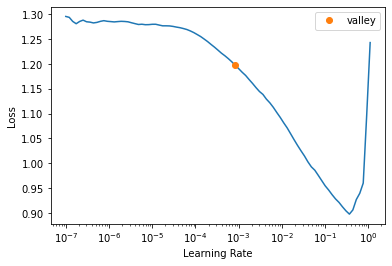

In [219]:
# Fastai has a useful function to estimate the best learning rate to use.
learn_tab.lr_find()

In [220]:
# Fit the data. We are not fine-tuning here. We are learning from our training data alone.
learn_tab.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.537413,0.770312,0.726088,00:05
1,0.387218,1.062577,0.732909,00:05
2,0.352577,1.069417,0.718311,00:05
3,0.318735,1.123301,0.733351,00:05
4,0.308855,0.992836,0.732296,00:05


In [221]:
tab_test_df = testing_df[X_cols].copy()
tab_test_dl = learn_tab.dls.test_dl(tab_test_df,ordered=True)

In [222]:
preds, _, decoded = learn_tab.get_preds(dl=tab_test_dl, with_decoded=True)

In [223]:
decoded

tensor([2, 2, 2,  ..., 2, 2, 2])

In [224]:
decoded.unique()

tensor([0, 1, 2])

In [225]:
decoded[decoded == 0] = -1
decoded[decoded == 1] = 0
decoded[decoded == 2] = 1

In [226]:
decoded.unique()

tensor([-1,  0,  1])

In [227]:
f1_score(testing_df[y_col],decoded,average="weighted")

0.6423349568038629

### Large model